<a href="https://colab.research.google.com/github/sinaabbasi1/Trustworthy_AI/blob/main/Assignments/Assignment%2001/TAI_Assignment_01_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

First, we import libraries we'll need later.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor

import numpy as np
from tqdm.notebook import tqdm
import random
import copy

!pip install umap-learn
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap

!pip install cleverhans
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

Next, we'll set the random seeds for reproducability.

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Setting the device option:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The Data

We need CIFAR-10, so let's load it. But before that We need to calculate mean and standard deviation of our train data, so we can normalize it. Then we are going to define train and test transforms:

In [ ]:
ROOT = './data'
train_data = datasets.CIFAR10(root=ROOT, train=True, download=True)

mean = train_data.data.astype(float).mean() / 255
std = train_data.data.astype(float).std() / 255

100%|██████████| 170498071/170498071 [00:13<00:00, 12981060.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
train_data = datasets.CIFAR10(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


We create a validation set from 80% of our training data.

In [ ]:
VALID_RATIO = 0.2

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
############## don't forget using deepcopy in order to use transform

Let's check the numbers:

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 10000
Number of validation examples: 40000
Number of testing examples: 10000


As you can see the distribution of the validation set is almost balanced:

In [ ]:
valid_data_distribution = [0] * 10
for _, category in valid_data:
    valid_data_distribution[category] += 1

valid_data_distribution

[3976, 4004, 4017, 4010, 4005, 4019, 3971, 3978, 4020, 4000]

At the end of data processing, let's create our dataloaders:

In [ ]:
BATCH_SIZE = 64

train_dataloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# The Model

As I talked to TA of this course, we can use predefined ResNet-18 architecture by pytorch:

In [ ]:
model = models.resnet18(weights=None)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We have 10 classes, so:

In [ ]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(512, 10)

In [ ]:
# using potential GPU
model = model.to(device)

# Training


Let's start by defining our optimizer and loss function:

In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

We need a function to calculate the accuracy:

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Now, it's time to define our training and evaluation functions:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, data_labels)
            acc = calculate_accuracy(preds, data_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_dataloader, criterion)
    valid_loss, valid_acc = eval_model(model, valid_dataloader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 01
	Train loss: 1.710 | Train acc: 38.69%
	Valid loss: 1.735 | Valid acc: 38.15%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 1.368 | Train acc: 50.66%
	Valid loss: 1.543 | Valid acc: 46.61%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 1.179 | Train acc: 57.85%
	Valid loss: 1.263 | Valid acc: 54.57%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 1.024 | Train acc: 63.66%
	Valid loss: 1.267 | Valid acc: 55.19%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 0.877 | Train acc: 69.16%
	Valid loss: 1.240 | Valid acc: 58.16%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 0.746 | Train acc: 74.47%
	Valid loss: 1.333 | Valid acc: 57.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 0.614 | Train acc: 78.65%
	Valid loss: 1.237 | Valid acc: 60.54%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 0.479 | Train acc: 83.76%
	Valid loss: 1.499 | Valid acc: 55.38%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 0.390 | Train acc: 86.62%
	Valid loss: 1.452 | Valid acc: 59.59%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 0.320 | Train acc: 88.93%
	Valid loss: 1.611 | Valid acc: 58.29%


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

test_loss, test_acc = eval_model(model, test_dataloader, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 1.247 | Test acc: 60.26%


# UMAP

Dimensionality reduction using UMAP:

We need output of the CNN part of the model. This is known as `layer4` in the ResNet-18 model.

In [ ]:
model.layer4

We use feature extractor module from torchvision in order to extract features from backbone of the model.

In [ ]:
return_nodes = {
    "layer4": "layer4"
}

feature_extractor_model = create_feature_extractor(model, return_nodes=return_nodes)

Let's run our feature extractor model on the unseen data:

In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

intermediate_outputs = torch.tensor([]).to(device)
intermediate_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        intermediate_outputs = torch.cat((intermediate_outputs, torch.squeeze(feature_extractor_model(data_inputs)['layer4'])), 0)
        # also we need to do this on labels
        intermediate_labels = torch.cat((intermediate_labels, data_labels), 0)


print(intermediate_outputs.shape)
print(intermediate_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 512])
torch.Size([10000])


In [ ]:
intermediate_labels.dtype

torch.float32

We give the model inputs without the labels (unsupervised). And then plot the scatterplot to show the UMAP:

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(intermediate_outputs.cpu())

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

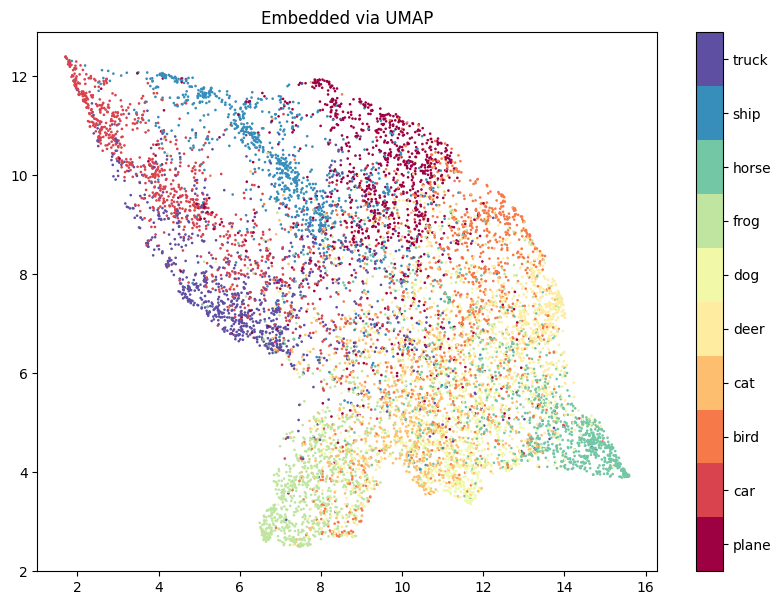

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intermediate_labels.to(dtype=torch.int).cpu(), s=0.8, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');

# Task 3

Perturbation, FGSM, and more...

In [ ]:
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std]),
                           transforms.RandomRotation(5, fill=(0,)),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ColorJitter(brightness=(0.8,1.2),contrast=(0.8, 1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
                           transforms.ElasticTransform(alpha=20.0)
                                     ])

test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified


In [ ]:
# x_fgm = fast_gradient_method(model, x, 0.3, np.inf)

In [ ]:
# x = projected_gradient_descent(model, x, 0.01, 40, np.inf)

Redefine the evaluation model, because we need to add FGM to each batch:

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    # with torch.no_grad(): # Deactivate gradients for the following code
    for index, (data_inputs, data_labels) in enumerate(tqdm(data_loader, desc='Evaluation', leave=False)):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        # FGSM
        if index < 50:
            data_inputs = fast_gradient_method(model, data_inputs, 0.3, np.inf)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Let's run the model on the new `test_dataloader` in order to examine the accuracy:

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

test_loss, test_acc = eval_model(model, test_dataloader, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 3.949 | Test acc: 21.17%


## UMAP

Let's run our feature extractor model on the unseen data. Here we have a new line in order to use FGM on test data.

In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

intermediate_outputs = torch.tensor([]).to(device)
intermediate_labels = torch.tensor([]).to(device)

# with torch.no_grad(): # Deactivate gradients for the following code
for index, (data_inputs, data_labels) in enumerate(tqdm(test_dataloader, desc='Evaluation', leave=False)):

    ## Step 1: Move input data to device (only strictly necessary if we use GPU)
    data_inputs = data_inputs.to(device)
    data_labels = data_labels.to(device)

    # FGSM
    if index < 50:
        data_inputs = fast_gradient_method(model, data_inputs, 0.3, np.inf)

    ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
    intermediate_outputs = torch.cat((intermediate_outputs, torch.squeeze(feature_extractor_model(data_inputs)['layer4'])), 0)
    # also we need to do this on labels
    intermediate_labels = torch.cat((intermediate_labels, data_labels), 0)


print(intermediate_outputs.shape)
print(intermediate_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 512])
torch.Size([10000])


Finally, we demonstrate the results using UMAP.

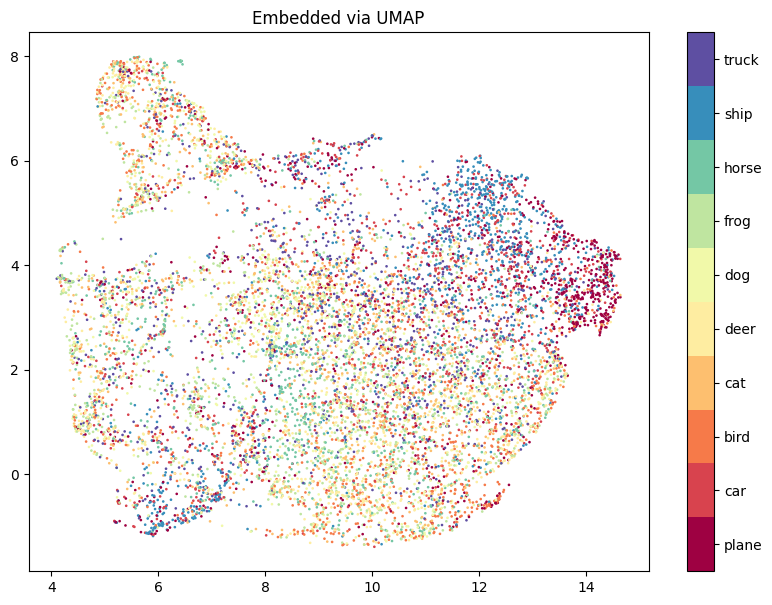

In [ ]:
with torch.no_grad():
    standard_embedding = umap.UMAP(random_state=42).fit_transform(intermediate_outputs.cpu())
fig, ax = plt.subplots(1, figsize=(10, 7))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intermediate_labels.to(dtype=torch.int).cpu(), s=0.8, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');

# Task 4



## Task 3 (with adversarial example)

Now, we are going to use our perturbations and FGM attack on the training data and see the result on the accuracy.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std]),
                           transforms.RandomRotation(5, fill=(0,)),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ColorJitter(brightness=(0.8,1.2),contrast=(0.8, 1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
                           transforms.ElasticTransform(alpha=20.0)
                                     ])

train_data = datasets.CIFAR10(root=ROOT, train=True, download=True, transform=train_transforms)
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

train_dataloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

Files already downloaded and verified


Some minor changes on `train_model`:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    for index, (data_inputs, data_labels) in enumerate(tqdm(data_loader, desc='Training', leave=False)):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        # FGSM: we are going to make the attack for 30% of the training data
        if index < 50:
            data_inputs = fast_gradient_method(model, data_inputs, 0.3, np.inf)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_dataloader, criterion)
    valid_loss, valid_acc = eval_model(model, valid_dataloader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'adversarial_example_checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 01
	Train loss: 1.913 | Train acc: 33.59%
	Valid loss: 1.759 | Valid acc: 44.86%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 1.734 | Train acc: 38.47%
	Valid loss: 1.700 | Valid acc: 44.28%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 1.679 | Train acc: 41.06%
	Valid loss: 1.650 | Valid acc: 47.47%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 1.625 | Train acc: 41.94%
	Valid loss: 1.702 | Valid acc: 47.20%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 1.594 | Train acc: 44.01%
	Valid loss: 1.686 | Valid acc: 47.74%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 1.542 | Train acc: 45.18%
	Valid loss: 1.692 | Valid acc: 48.54%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 1.528 | Train acc: 45.51%
	Valid loss: 1.619 | Valid acc: 49.69%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 1.515 | Train acc: 46.01%
	Valid loss: 1.586 | Valid acc: 49.58%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 1.463 | Train acc: 48.61%
	Valid loss: 1.658 | Valid acc: 49.49%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 1.427 | Train acc: 49.52%
	Valid loss: 1.721 | Valid acc: 46.46%


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('adversarial_example_checkpoint.pt'))

test_loss, test_acc = eval_model(model, test_dataloader, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 2.365 | Test acc: 39.61%


### UMAP

In [ ]:
# model = models.resnet18(weights=None)
# model.fc = nn.Linear(512, 10)
# # using potential GPU
# model = model.to(device)
# optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# criterion = criterion.to(device)

In [ ]:
feature_extractor_model = create_feature_extractor(model, return_nodes=return_nodes)

In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

intermediate_outputs = torch.tensor([]).to(device)
intermediate_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        intermediate_outputs = torch.cat((intermediate_outputs, torch.squeeze(feature_extractor_model(data_inputs)['layer4'])), 0)
        # also we need to do this on labels
        intermediate_labels = torch.cat((intermediate_labels, data_labels), 0)


print(intermediate_outputs.shape)
print(intermediate_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 512])
torch.Size([10000])


We give the model inputs without the labels (unsupervised). And then plot the scatterplot to show the UMAP:

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

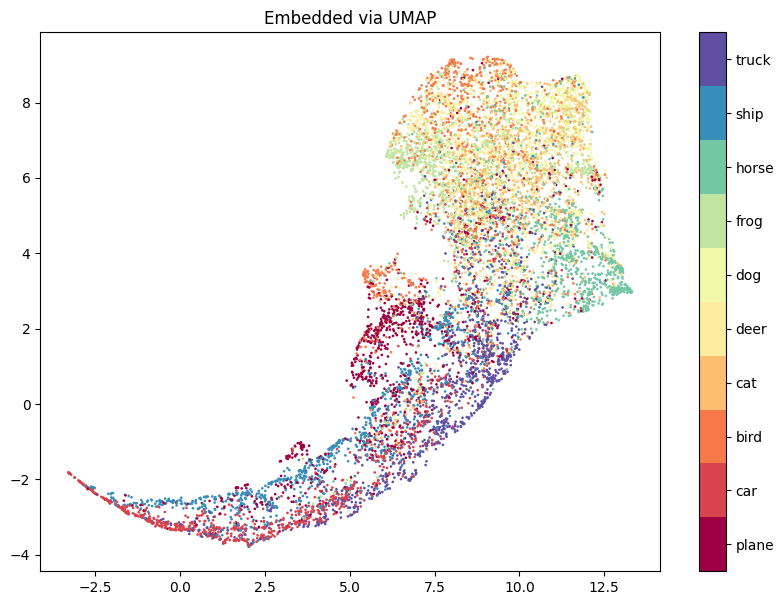

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(intermediate_outputs.cpu())

fig, ax = plt.subplots(1, figsize=(10, 7))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intermediate_labels.to(dtype=torch.int).cpu(), s=0.8, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');

## Task 2 (with adversarial example)

The difference here is our model trained on the adversarial examples.

Redefine the evaluation model, because we need to add FGM to each batch:

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    # with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Let's run the model on the new `test_dataloader` in order to examine the accuracy:

In [ ]:
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified


In [ ]:
model.load_state_dict(torch.load('adversarial_example_checkpoint.pt'))

test_loss, test_acc = eval_model(model, test_dataloader, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 1.528 | Test acc: 50.65%


### UMAP

Let's run our feature extractor model on the unseen data. Here we have a new line in order to use FGM on test data.

In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

intermediate_outputs = torch.tensor([]).to(device)
intermediate_labels = torch.tensor([]).to(device)

# with torch.no_grad(): # Deactivate gradients for the following code
for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

    ## Step 1: Move input data to device (only strictly necessary if we use GPU)
    data_inputs = data_inputs.to(device)
    data_labels = data_labels.to(device)

    data_inputs = fast_gradient_method(model, data_inputs, 0.3, np.inf)

    ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
    intermediate_outputs = torch.cat((intermediate_outputs, torch.squeeze(feature_extractor_model(data_inputs)['layer4'])), 0)
    # also we need to do this on labels
    intermediate_labels = torch.cat((intermediate_labels, data_labels), 0)


print(intermediate_outputs.shape)
print(intermediate_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 512])
torch.Size([10000])


Finally, we demonstrate the results using UMAP.

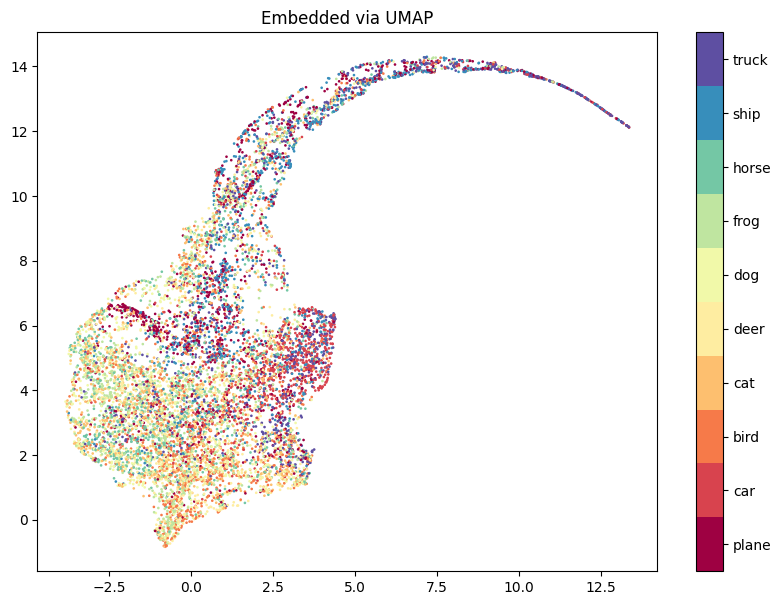

In [ ]:
with torch.no_grad():
    standard_embedding = umap.UMAP(random_state=42).fit_transform(intermediate_outputs.cpu())
fig, ax = plt.subplots(1, figsize=(10, 7))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intermediate_labels.to(dtype=torch.int).cpu(), s=0.8, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');

# Task 6 (Angular Loss)

In [ ]:
!pip install pytorch_metric_learning
from pytorch_metric_learning import losses
loss_func = losses.AngularLoss(alpha=40)
# loss = loss_func(embeddings, labels) # in your training for-loop

## Task 2

We have a new loss function, so we update our criterion:

In [ ]:
criterion = losses.AngularLoss(alpha=40)
criterion = criterion.to(device)

We need ResNet-18 model with no change and with 1000 output dimension:

In [ ]:
model = models.resnet18(weights=None)

# using potential GPU
model = model.to(device)

Training loop using new criterion:

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, data_labels)
        acc = calculate_accuracy(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss and accuracy per epoch
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, data_labels)
            acc = calculate_accuracy(preds, data_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
train_data = datasets.CIFAR10(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


We create a validation set from 80% of our training data.

In [ ]:
VALID_RATIO = 0.2

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
############## don't forget using deepcopy in order to use transform

In [ ]:
BATCH_SIZE = 64

train_dataloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_dataloader, criterion)
    valid_loss, valid_acc = eval_model(model, valid_dataloader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'angular_checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 01
	Train loss: 86.377 | Train acc: 0.02%
	Valid loss: 95.890 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 86.441 | Train acc: 0.00%
	Valid loss: 90.584 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 86.323 | Train acc: 0.00%
	Valid loss: 91.100 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 87.212 | Train acc: 0.01%
	Valid loss: 92.200 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 86.507 | Train acc: 0.00%
	Valid loss: 95.461 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 86.636 | Train acc: 0.00%
	Valid loss: 91.874 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 86.276 | Train acc: 0.04%
	Valid loss: 91.381 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 86.528 | Train acc: 0.01%
	Valid loss: 91.930 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 86.274 | Train acc: 0.00%
	Valid loss: 91.606 | Valid acc: 0.01%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 86.411 | Train acc: 0.01%
	Valid loss: 93.831 | Valid acc: 0.01%


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('angular_checkpoint.pt'))

# test_loss, test_acc = eval_model(model, test_dataloader, criterion)
# print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

<All keys matched successfully>

In [ ]:
# Set model to eval mode
model.train()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

final_train_outputs = torch.tensor([]).to(device)
final_train_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(train_dataloader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        final_train_outputs = torch.cat((final_train_outputs, torch.squeeze(model(data_inputs))), 0)
        # also we need to do this on labels
        final_train_labels = torch.cat((final_train_labels, data_labels), 0)


print(final_train_outputs.shape)
print(final_train_labels.shape)

Training:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 1000])
torch.Size([10000])


In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

final_outputs = torch.tensor([]).to(device)
final_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        final_outputs = torch.cat((final_outputs, torch.squeeze(model(data_inputs))), 0)
        # also we need to do this on labels
        final_labels = torch.cat((final_labels, data_labels), 0)


print(final_outputs.shape)
print(final_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 1000])
torch.Size([10000])


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(final_train_outputs.cpu(), final_train_labels.cpu())
preds = neigh.predict(final_outputs.cpu())

preds = torch.from_numpy(preds)

correct = preds.eq(final_labels.cpu()).sum()
acc = correct.float() / preds.shape[0]
acc.item()

0.19099999964237213

### UMAP

In [ ]:
feature_extractor_model = create_feature_extractor(model, return_nodes=return_nodes)

Let's run our feature extractor model on the unseen data:

In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

intermediate_outputs = torch.tensor([]).to(device)
intermediate_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        intermediate_outputs = torch.cat((intermediate_outputs, torch.squeeze(feature_extractor_model(data_inputs)['layer4'])), 0)
        # also we need to do this on labels
        intermediate_labels = torch.cat((intermediate_labels, data_labels), 0)


print(intermediate_outputs.shape)
print(intermediate_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 512])
torch.Size([10000])


In [ ]:
intermediate_labels.dtype

torch.float32

We give the model inputs without the labels (unsupervised). And then plot the scatterplot to show the UMAP:

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(intermediate_outputs.cpu())

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

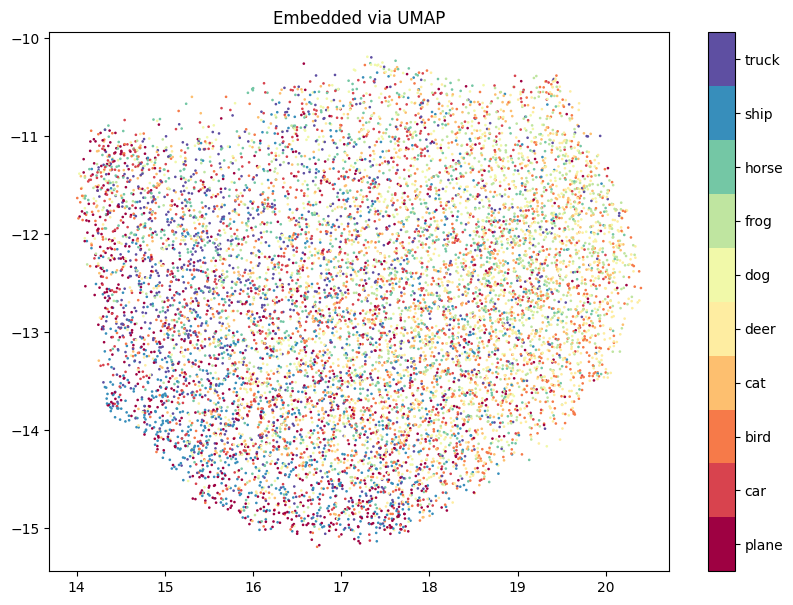

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intermediate_labels.to(dtype=torch.int).cpu(), s=0.8, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');

## Task 3

Now we run our training loop and use the validation set to save the best checkpoint of the model:

In [ ]:
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std]),
                           transforms.RandomRotation(5, fill=(0,)),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ColorJitter(brightness=(0.8,1.2),contrast=(0.8, 1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
                           transforms.ElasticTransform(alpha=20.0)
                                     ])

test_data = datasets.CIFAR10(root=ROOT, train=False, download=True, transform=test_transforms)

test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
model.load_state_dict(torch.load('angular_checkpoint.pt'))

# test_loss, test_acc = eval_model(model, test_dataloader, criterion)
# print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

<All keys matched successfully>

In [ ]:
# Set model to eval mode
model.train()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

final_train_outputs = torch.tensor([]).to(device)
final_train_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(train_dataloader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        final_train_outputs = torch.cat((final_train_outputs, torch.squeeze(model(data_inputs))), 0)
        # also we need to do this on labels
        final_train_labels = torch.cat((final_train_labels, data_labels), 0)


print(final_train_outputs.shape)
print(final_train_labels.shape)

Training:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 1000])
torch.Size([10000])


In [ ]:
# Set model to eval mode
model.eval()

# loss and accuracy per epoch
epoch_loss = 0
epoch_acc = 0

final_outputs = torch.tensor([]).to(device)
final_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_dataloader, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        final_outputs = torch.cat((final_outputs, torch.squeeze(model(data_inputs))), 0)
        # also we need to do this on labels
        final_labels = torch.cat((final_labels, data_labels), 0)


print(final_outputs.shape)
print(final_labels.shape)

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

torch.Size([10000, 1000])
torch.Size([10000])


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(final_train_outputs.cpu(), final_train_labels.cpu())
preds = neigh.predict(final_outputs.cpu())

preds = torch.from_numpy(preds)

correct = preds.eq(final_labels.cpu()).sum()
acc = correct.float() / preds.shape[0]
acc.item()

0.18379999697208405